# Building a Robot Judge
## ETH Zurich, Spring 2019

## Problem Set 1

Author: Philipp Nikolaus

## 1. Environment

In [1]:
import json
import os
import pickle
import random
import string
from collections import Counter
from itertools import groupby
from string import punctuation

import numpy as np
import pandas as pd
import spacy
from matplotlib import pyplot as plt
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, f1_score, roc_auc_score,
                             roc_curve)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import (GridSearchCV, KFold, StratifiedKFold,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

tqdm.pandas()



%matplotlib inline


## 2. Data Prep

In [2]:
n_samples = None # use only a subset of the available data for computational reasons
seed = 42
random.seed(seed)

cases = os.listdir('./data/cases')

meta_data = pd.read_csv('./data/case_metadata.csv')
meta_data = meta_data.drop_duplicates(subset=["caseid"],keep="first")
meta_data = meta_data.rename(index=meta_data.caseid).drop("caseid", axis=1).to_dict(orient="index")

In [4]:
data = {}

for i, case in tqdm(enumerate(cases)):
    case_id = case[5:].replace('.txt','')
    data[case_id] = {
        "filename": case,
        "year": int(case[:4]),
        "doc_raw": open(os.path.join("./data/cases",case),"r").read()
    }

case_ids = list(data.keys())

5762it [00:02, 2268.22it/s]


In [5]:
for case_id, case in data.items():
    data[case_id]["x_republican"] = meta_data[case_id]["x_republican"]
    data[case_id]["case_reversed"] = meta_data[case_id]["case_reversed"]
    data[case_id]["judge_id"] = meta_data[case_id]["judge_id"]
    data[case_id]["log_cites"] = meta_data[case_id]["log_cites"]

In [6]:
print(len(data))
print(list(data.keys())[:20])

5762
['X3H0E7', 'X4AKRO', 'X19E92S003', 'X3GBO8', 'X3ILN5', 'X3IJNV', 'X3BF7F', 'X391D1', 'X4A2GQ', 'X4A1L0', 'X353TJ', 'X36G10', 'X3SL02', 'X37OSS', 'X3CCEO', 'X41ESC', 'X16LL7S003', 'X3SPML', 'X44HV6', 'XABNR8']


In [7]:
print(json.dumps(data['X3GGN6'], indent=5))

{
     "filename": "1929_X3GGN6.txt",
     "year": 1929,
     "doc_raw": " PARKER , Circuit Judge.\nThis is an appeal from a verdict and judgment rendered in favor of the administrators of James E. Tyler, deceased, who paid under protest a portion of the federal estate tax assessed against the estate which came into their hands and instituted suit to recover it back as allowed by statute.\nThe portion of the tax disputed is that assessed against the estate because of including in the value thereof property which was held by decedent and his wife as tenants by the entireties, and which upon the death of decedent vested in the wife as sole and exclusive owner.\nThe facts in the case are few and undisputed.\nIn November, 1917, decedent transferred 349 shares of stock in the Kimball-Tyler Company to himself and wife, creating therein under the laws of Maryland an estate by the entireties in their favor.\nOn his death in 1918, his wife became vested under the Maryland law with the sole owne

In [8]:
# additional steps for nlp-pipeline

def replace_numeric(doc):
    doc = ["number" if token.like_num or token.is_digit else token.text for token in doc]
    doc = ' '.join(doc)
    return nlp.make_doc(doc)

# def filter_words(doc):
#     doc = [token.text for i,token in enumerate(doc) if not token.is_punct and not token.is_space]
#     doc = ' '.join(doc)
#     return nlp.make_doc(doc)

nlp = spacy.load('en_core_web_sm')

nlp.add_pipe(replace_numeric, name='replace_numeric', first=True)
# nlp.add_pipe(filter_words, name='filter_words', after='replace_numeric')

print(nlp.pipe_names)

['replace_numeric', 'tagger', 'parser', 'ner']


In [9]:
## processing of raw documents through nlp pipeline

for case_id, case in tqdm(data.items()):
    data[case_id]["doc_spacy"] = nlp(case["doc_raw"])

100%|██████████| 5762/5762 [39:17<00:00,  2.44it/s]


In [10]:
def normalize_token(token):
    """Normalize Token. Get Lemma (base form) and remove any punctuation
    """
    lemma = token.lemma_.lower().strip()
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation))
    return nopunct

def keep_token(token):
    keep_token = not token.is_punct and not token.is_space and not token.is_stop and not token.like_num
    return keep_token

In [11]:
for case_id, case in tqdm(data.items()):
    tokens = []
    for token in case["doc_spacy"]:
        if keep_token(token):
            tokens.append(normalize_token(token))

    data[case_id]["doc_clean"] = tokens

100%|██████████| 5762/5762 [00:47<00:00, 120.22it/s]


In [12]:
with open("./data/cases_preprocessed_full.pkl", "wb") as f:
    pickle.dump(data, f)

## 3. EDA

In [13]:
## splitting of preprocessed docs in words and sentences

for case_id, case in tqdm(data.items()):
    sentences = [sentence for sentence in case["doc_spacy"].sents]
    words = [tok for tok in case["doc_spacy"]]
    
    data[case_id]["sentences"] = sentences
    data[case_id]["words"] = words
    data[case_id]["num_sentences"] = len(sentences)
    data[case_id]["num_words"] = len(words)
    data[case_id]["num_letters"] = np.sum([len(word) for word in words])

100%|██████████| 5762/5762 [00:39<00:00, 146.35it/s]


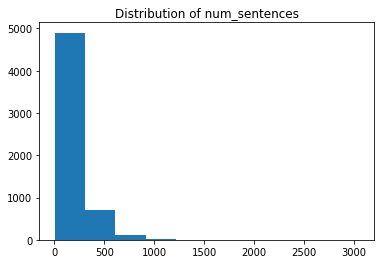

In [14]:
plt.hist([case["num_sentences"] for case in data.values()])
plt.title("Distribution of num_sentences")
plt.show()

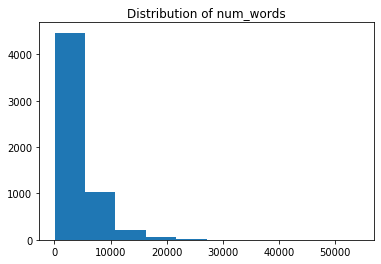

In [15]:
plt.hist([case["num_words"] for case in data.values()])
plt.title("Distribution of num_words")
plt.show()

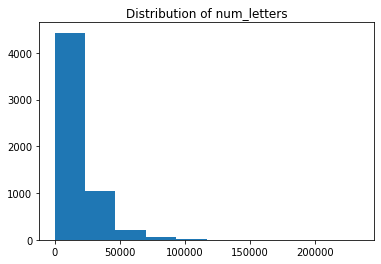

In [16]:
plt.hist([case["num_letters"] for case in data.values()])
plt.title("Distribution of num_letters")
plt.show()

## 4. POS Frequency

In [17]:
## using the POS tags that come as part of the standard spacy nlp pipeline and counting nouns, verbs and adjectives

for case_id, case in tqdm(data.items()):
    pos = [tok.pos_ for tok in case['words']]

    data[case_id]['POS'] = pos
    data[case_id]['num_nouns'] = pos.count("NOUN")
    data[case_id]['num_verbs'] = pos.count("VERB")
    data[case_id]['num_adj'] = pos.count("ADJ")

100%|██████████| 5762/5762 [00:03<00:00, 1447.43it/s]


In [18]:
## taking the average of the number of nouns, verbs and adjectives for each year
years = list(set([case["year"] for case in data.values()]))

pos_data = {
    "noun_mean": [],
    "verb_mean": [],
    "adj_mean": [],
    "noun_freq": [],
    "verb_freq": [],
    "adj_freq": []
}
for year in years:
    year_cases = [case for case in data.values() if case["year"]==year]

    noun_mean = np.mean([c["num_nouns"] for c in year_cases])
    verb_mean = np.mean([c["num_verbs"] for c in year_cases])
    adj_mean = np.mean([c["num_adj"] for c in year_cases])

    pos_data["noun_mean"].append(noun_mean)
    pos_data["verb_mean"].append(verb_mean)
    pos_data["adj_mean"].append(adj_mean)
    pos_data["noun_freq"].append(noun_mean / (noun_mean + verb_mean + adj_mean))
    pos_data["verb_freq"].append(verb_mean / (noun_mean + verb_mean + adj_mean))
    pos_data["adj_freq"].append(adj_mean / (noun_mean + verb_mean + adj_mean))

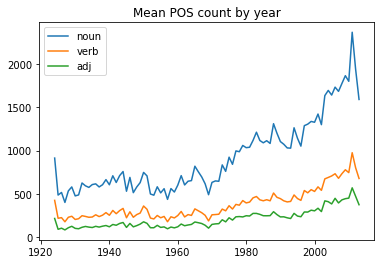

In [19]:
plt.plot(years, pos_data["noun_mean"])
plt.plot(years, pos_data["verb_mean"])
plt.plot(years, pos_data["adj_mean"])
plt.legend(['noun', 'verb', 'adj'], loc='upper left')
plt.title("Mean POS count by year")
plt.show()

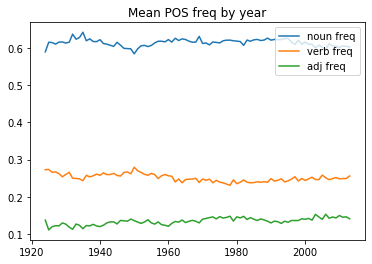

In [20]:
plt.plot(years, pos_data["noun_freq"])
plt.plot(years, pos_data["verb_freq"])
plt.plot(years, pos_data["adj_freq"])
plt.legend(['noun freq', 'verb freq', 'adj freq'], loc='upper right')
plt.title("Mean POS freq by year")
plt.show()

## 5. Trigrams ending on nouns
### 5.1 Feature Extraction

In [21]:
## function to take in a preprocessed document and return a list of all lemmatized 3-grams.
## Only 3-grams within the same sentence are considered.

trigram_features = []
case_trigrams = {}

for case_id, case in tqdm(data.items()):
    trigrams = []
    tokens = [(normalize_token(tok), tok.pos_) for tok in case["doc_spacy"] if keep_token(tok)]
    for i, (tok, pos) in enumerate(tokens):
        if (pos=="NOUN") & (i >= 2):

            feature = "_".join([tok[0] for tok in tokens[i-2:i+1]])
            trigram_features.append(feature)
            trigrams.append(feature)
    
    case_trigrams[case_id] = {"total_count": len(trigrams), "trigram_counts": dict(Counter(trigrams))}

trigram_count = Counter(trigram_features)
top_trigrams = [trigram[0] for trigram in trigram_count.most_common(1000)]

100%|██████████| 5762/5762 [00:47<00:00, 120.85it/s]


In [22]:
trigram_data = {}
for case_id, case_counts in case_trigrams.items():
    features = {}
    for trigram in top_trigrams:
        if case_counts["total_count"] > 0:
            features[trigram] = case_counts["trigram_counts"].get(trigram, 0) / case_counts["total_count"]
        else:
            features[trigram] = 0
    trigram_data[case_id] = features

In [23]:
trigram_df = pd.DataFrame.from_dict(trigram_data, orient="index")

In [24]:
cases_reversed = {}
for case_id, case in data.items():
    if not case["case_reversed"] in cases_reversed.keys():
        cases_reversed[case["case_reversed"]] = [case_id]
    else:
        cases_reversed[case["case_reversed"]].append(case_id)


cases_sampled = cases_reversed[0] + random.sample(cases_reversed[1], 2118)
random.shuffle(cases_sampled)

In [25]:
trigram_df = trigram_df.loc[cases_sampled,:]

In [26]:
arr = sparse.csr_matrix(trigram_df.values)
arr_norm = StandardScaler(with_mean=False).fit_transform(arr)

In [27]:
trigram_df = pd.DataFrame(arr_norm.toarray(), columns=trigram_df.columns, index=trigram_df.index)

# let's check that it worked
trigram_df.apply(lambda col: np.std(col), axis=0)

number_number_number           1.0
number_sct_number              1.0
number_number_sct              1.0
number_us_number               1.0
us_number_number               1.0
                              ... 
law_enforcement_official       1.0
lake_city_market               1.0
number_srep_number             1.0
number_approximately_number    1.0
question_present_appeal        1.0
Length: 1000, dtype: float64

In [28]:
# the trigram dataframe will be used as the training data
trigram_df.head()

,number_number_number,number_sct_number,number_number_sct,number_us_number,us_number_number,sct_number_number,number_f2d_number,number_led2d_number,led2d_number_number,f2d_number_number,...,state_court_judgment,s_w_number,number_9th_cir1994,comp_st_number,cir_number_curiam,law_enforcement_official,lake_city_market,number_srep_number,number_approximately_number,question_present_appeal
X3DI40,0.345948,0.766873,0.812473,0.837669,0.883074,0.934576,0.728821,0.000000,0.000000,1.174939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X2NN3I,0.947192,1.259802,1.334712,1.490779,1.450693,0.511767,1.117471,0.555170,0.618844,1.654425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X44TGF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X2A9ER,0.386230,0.214042,0.226769,0.233802,0.246474,0.260849,0.650947,0.377296,0.420569,1.499139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X4VO3P,0.999027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5.2 Logistic Regression

In [29]:
## based on the cases in the training data, we collect the respective response (case_reversed)

y = [data[case_id]["case_reversed"] for case_id in cases_sampled]

In [30]:
## randomly splitting the data into training and test set

X_train, X_test, y_train, y_test = train_test_split(trigram_df, y, test_size=0.3, random_state=seed, stratify=y)

In [31]:
## fitting the logistic regression model

model = LogisticRegression()
model = model.fit(X_train, y_train)

In [32]:
## creating predictions for the training and the test set

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [33]:
print('F1-Score','\n')
print('Training:',f1_score(y_train,train_pred))
print('Test:',f1_score(y_test,test_pred))

F1-Score 

Training: 0.7983924983255191
Test: 0.5127388535031847


In [34]:
print('Accuracy-Score','\n')
print('Training:',accuracy_score(y_train,train_pred))
print('Test:',accuracy_score(y_test,test_pred))

Accuracy-Score 

Training: 0.796964586846543
Test: 0.5184893784421715


### 5.3 Logistic Regression (GridSearch)

In [35]:
## defining the parameter grid, fitting the 10-fold CV and reporting the optimal parameters found

param_grid = {
    'penalty' : ['l1','l2'], 
    'C': [10**(-i) for i in range(-2, 6)]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

model = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=cv
)

model.fit(X_train, y_train)
model.best_params_

{'C': 0.0001, 'penalty': 'l2'}

In [36]:
## creating predictions for the test set

test_probs = model.predict_proba(X_test)[:,1]

In [37]:
print('F1-Score:',f1_score(y_test, np.round(test_probs)))
print('Accuracy-Score:',accuracy_score(y_test, np.round(test_probs)))

F1-Score: 0.5311740890688259
Accuracy-Score: 0.5444531864673485


In [38]:
## calculating false positive and true positive rates

fpr, tpr, _ = roc_curve(y_test, test_probs)

In [39]:
print('AUC-Score:',auc(fpr, tpr))

AUC-Score: 0.5728197890358045


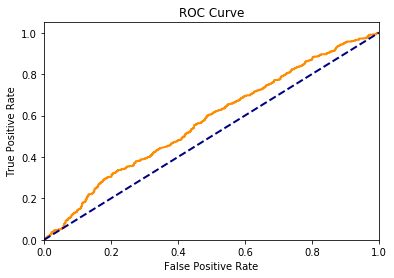

In [40]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## 6. Sentiment Analysis

In [41]:
## creating a new dataset iterating over all documents of the original and for each sentence in each document
## appending a new row. for each sentence, all tokens are converted to lower case and joined to a single with
## whitespaces in between.
sia = SentimentIntensityAnalyzer()

sentence_data = {}
for case_id, case in tqdm(data.items()):
    i = 0
    for s in case["sentences"]:
        tokens = [normalize_token(tok) for tok in s if keep_token(tok)]
        sentence = " ".join(tokens)

        if len(sentence) > 0:
            sentence_data[f"{case_id}_{i}"] = {
                "sentence": sentence,
                "len": len(tokens),
                "sentiment": sia.polarity_scores(sentence)['compound']
            }
            i+=1
        else:
            continue

sentence_data.keys()

100%|██████████| 5762/5762 [03:25<00:00, 28.09it/s]


3CCIA_160', 'X3CCIA_161', 'X3CCIA_162', 'X3CCIA_163', 'X3CCIA_164', 'X3CCIA_165', 'X3CCIA_166', 'X3CCIA_167', 'X3CCIA_168', 'X3CCIA_169', 'X3CCIA_170', 'X3CCIA_171', 'X3CCIA_172', 'X3CCIA_173', 'X3CCIA_174', 'X3CCIA_175', 'X3CCIA_176', 'X3CCIA_177', 'X3CCIA_178', 'X3CCIA_179', 'X3CCIA_180', 'X3CCIA_181', 'X3CCIA_182', 'X3CCIA_183', 'X3CCIA_184', 'X3CCIA_185', 'X3CCIA_186', 'X3CCIA_187', 'X3CCIA_188', 'X3CCIA_189', 'X3CCIA_190', 'X3CCIA_191', 'X3CCIA_192', 'X3CCIA_193', 'X3CCIA_194', 'X3CCIA_195', 'X3CCIA_196', 'X3CCIA_197', 'X3CCIA_198', 'X3CCIA_199', 'X3CCIA_200', 'X3CCIA_201', 'X3CCIA_202', 'X3CCIA_203', 'X3CCIA_204', 'X3CCIA_205', 'X3CCIA_206', 'X3CCIA_207', 'X3CCIA_208', 'X3CCIA_209', 'X3CCIA_210', 'X3CCIA_211', 'X3CCIA_212', 'X3CCIA_213', 'X3CCIA_214', 'X3CCIA_215', 'X3CCIA_216', 'X3CCIA_217', 'X3CCIA_218', 'X3CCIA_219', 'X3CCIA_220', 'X3CCIA_221', 'X3CCIA_222', 'X3CCIA_223', 'X3CCIA_224', 'X3CCIA_225', 'X3CCIA_226', 'X3CCIA_227', 'X3CCIA_228', 'X3CCIA_229', 'X3CCIA_230', 'X3CCIA_

In [42]:
print(json.dumps(sentence_data['X3CCIA_161'], indent=4))

{
    "sentence": "perversion natural thought natural language continuous co operation cinematographic series distinct conspiracy single number",
    "len": 14,
    "sentiment": -0.1027
}


In [43]:
# lowest sentiment sentences
for i, item in enumerate(sorted(sentence_data.values(), key=lambda item: item["sentiment"])[:5]):
    print(i)
    print(f"Sentiment score: {item['sentiment']}")
    print(f"Sentence: {item['sentence']}")
    print("")

0
Sentiment score: -0.9944
Sentence: relation crime violence drug trafficking crime include crime violence drug trafficking crime provide enhanced punishment commit use deadly dangerous weapon device prosecute court united states use carry firearm shall addition punishment provide crime violence drug trafficking crime sentence imprisonment number year firearm short barreled rifle short barrel shotgun semiautomatic assault weapon imprisonment number year firearm machinegun destructive device equip firearm silencer firearm muffler imprisonment number year

1
Sentiment score: -0.9924
Sentence: virginia law death penalty impose defendant jury find reasonable doubt probability base evidence prior history defendant circumstance surround commission offense accuse commit criminal act violence constitute continue threat society dangerousness criterion conduct commit offense outrageously wantonly vile horrible inhuman involve torture depravity mind aggravate battery victim vileness criterion

2


In [44]:
# highest sentiment sentences
for i, item in enumerate(sorted(sentence_data.values(), key=lambda item: item["sentiment"])[-5:]):
    print(i)
    print(f"Sentiment score: {item['sentiment']}")
    print(f"Sentence: {item['sentence']}")
    print("")

0
Sentiment score: 0.9924
Sentence: member association time issuance statement r s shannon general superintendent production rocky mountain division announce petitioner ready meet committee recognize union exclusive bargaining agency employee petitioner address letter employee state wish represent union choose representative entitle deal management management prepared deal organization employee choose undertake management interference letter write march number union take exception refusal petitioner recognize representative employee enter contract union result communication meeting hold committee representative petitioner shannon reiterate position petitioner set forth statement working condition issue september shortly passage national labor relations board act july number majority employee sign petition designate union collective bargaining agency august number number date attempt collective bargaining passage act union duly designate representative majority employee purpose august n

## 7. Cosine Similarity

In [45]:
tfidf = TfidfVectorizer()
sentence_tfidf = tfidf.fit_transform([item["sentence"] for item in sentence_data.values()])

In [46]:
sentence_tfidf

<985210x89104 sparse matrix of type '<class 'numpy.float64'>'
	with 8871003 stored elements in Compressed Sparse Row format>

In [47]:
## calculating cosine similarities for the first 5000 sentences, resulting in a 5000x5000 matrix

cosine_sim = cosine_similarity(sentence_tfidf[:5000,:])

cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.51511195, ..., 0.        , 0.        ,
        0.13179701],
       [0.        , 0.51511195, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.19562162,
        0.11867238],
       [0.        , 0.        , 0.        , ..., 0.19562162, 1.        ,
        0.19586489],
       [0.        , 0.13179701, 0.        , ..., 0.11867238, 0.19586489,
        1.        ]])

In [48]:
highest_cs = np.where((cosine_sim>0.8)&(cosine_sim<0.9))
highest_cs = [(highest_cs[0][i], highest_cs[1][i]) for i in range(highest_cs[0].shape[0])]

lowest_cs = np.where((cosine_sim>0.1)&(cosine_sim<0.2))
lowest_cs = [(lowest_cs[0][i], lowest_cs[1][i]) for i in range(lowest_cs[0].shape[0])]

In [49]:
# high cosine similarity sentences
for i, item in enumerate(random.sample(highest_cs, 3)):
    sent_0 = list(sentence_data.values())[item[0]]["sentence"]
    sent_1 = list(sentence_data.values())[item[1]]["sentence"]

    print(i)
    print(item)
    print(f"cosine similarity: {cosine_sim[item]}")
    print(f"Sentence 0: {sent_0}")
    print("")
    print(f"Sentence 1: {sent_1}")
    print("")
    print("")

0
(2307, 2762)
cosine similarity: 0.8803732930100221
Sentence 0: number

Sentence 1: number number number led2d number number


1
(2766, 2499)
cosine similarity: 0.8803732930100221
Sentence 0: number number number led2d number number

Sentence 1: number


2
(4607, 4782)
cosine similarity: 0.8294599263185114
Sentence 0: number number led2d number number

Sentence 1: number




In [50]:
# low cosine similarity sentences
for i, item in enumerate(random.sample(lowest_cs, 3)):
    sent_0 = list(sentence_data.values())[item[0]]["sentence"]
    sent_1 = list(sentence_data.values())[item[1]]["sentence"]

    print(i)
    print(item)
    print(f"cosine similarity: {cosine_sim[item]}")
    print(f"Sentence 0: {sent_0}")
    print("")
    print(f"Sentence 1: {sent_1}")
    print("")
    print("")

0
(3385, 3287)
cosine similarity: 0.11831757793928638
Sentence 0: assume moment florida power action construe invitation access pole nonetheless clear invitation subject base certain condition agree annual pole rate

Sentence 1: petitioner case florida power stranger industry practice


1
(4287, 2672)
cosine similarity: 0.1407065253577484
Sentence 0: number number number led

Sentence 1: number number board clearly act properly exercise authority hold inquiry effect appropriate remedy number warrant unfair labor practice charge simple term


2
(1854, 846)
cosine similarity: 0.14699694639913058
Sentence 0: number

Sentence 1: preparation bureau select approximately number block achieve deem appropriate sample size number poststrata previously develop february number bureau employee visit sample block list housing unit find identify approximately number household




## 8. KMeans Clustering

In [51]:
## creating the KMeans instance. i limit the number of initializations to 3.

kmeans = KMeans(
    n_clusters=20, 
    verbose=0, 
    n_init=3, 
    random_state=seed
)
kmeans = kmeans.fit(sentence_tfidf)

In [52]:
## group training sentences by cluster
sentence_labels = kmeans.predict(sentence_tfidf)

sentences_by_cluster = {}
for i, (item, label) in tqdm(enumerate(zip(sentence_data.values(), sentence_labels))):
    if not label in sentences_by_cluster.keys():
        sentences_by_cluster[label] = [item["sentence"]]
    else:
        sentences_by_cluster[label].append(item["sentence"])

985210it [00:01, 600226.08it/s]


In [53]:
## reporting 5 examples for each cluster

for label in range(20):
    sentences = sentences_by_cluster[label]
    print(f'Label: {label}')
    for i, sentence in enumerate(random.sample(sentences, 5)):
        print(f"{i}: {sentence}")
    print('==================================')

Label: 0
0: gomillion v lightfoot number us number number number sct
1: pennsylvania v union gas number us number number sct
2: deny number us number number sct
3: cunningham number us number number number sct
4: number us number number sct
Label: 1
0: ultimate task ascertain policy decision congress enact statutory provision
1: number internal quotation mark omit
2: violation monthly average limit measurement basis limited number sample take month accord term npdes permit
3: bellarmino duran resident denver colorado bring household spanish speak educate grade school wyoming idaho colorado
4: d
Label: 2
0: petition review decision united states board tax appeals enter march number number deny deficiency  number determine commissioner respondent income tax number
1: petitioner claim coffey v united states number us number number sct
2: wade v united states
3: centennial savings bank fsb v united states number fsupp
4: miller v united states number ct
Label: 3
0: appellant claim conveyan